<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/Copy_of_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [22]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import joblib
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input

# Set the Seaborn style for all plots
sns.set_style("darkgrid")

In [40]:
# Define Bitcoin ticker
BTC_TICKER = "BTC-USD"

# Function to fetch historical price data
def fetch_bitcoin_data(ticker, years=5):
    print(f"Fetching Bitcoin data for the last {years} years...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period=f"{years}y")  # Fetch last `years` of data

    if df.empty:
        print("Error: No historical data found for Bitcoin.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Fetch Bitcoin data
btc_df = fetch_bitcoin_data(BTC_TICKER, years=5)

if btc_df is not None:
    # Save full dataset
    btc_df.to_csv("bitcoin_prices_full.csv", index=False)
    print("Full Bitcoin data saved.")

    # Extract last 30 days
    last_30_days = btc_df.tail(30)
    last_30_days.to_csv("bitcoin_last_30_days.csv", index=False)
    print("Last 30 days of Bitcoin data saved.")

Fetching Bitcoin data for the last 5 years...
Full Bitcoin data saved.
Last 30 days of Bitcoin data saved.


In [176]:
# Load the Bitcoin dataset
df = pd.read_csv("bitcoin_prices_full.csv")

# Convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [177]:
# Ensure data is sorted by date
df = df.sort_values(by="Date")

# Display basic info
print(df.info())  # Check data types and missing values
print(df.head())  # Preview first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1827 non-null   datetime64[ns]
 1   Close   1827 non-null   float64       
 2   High    1827 non-null   float64       
 3   Low     1827 non-null   float64       
 4   Open    1827 non-null   float64       
 5   Volume  1827 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.8 KB
None
        Date        Close         High          Low         Open       Volume
0 2020-03-18  5238.438477  5331.833984  5069.335938  5227.113770  37878801016
1 2020-03-19  6191.192871  6329.735840  5236.968750  5245.416504  51000731797
2 2020-03-20  6198.778320  6844.261719  5865.781738  6191.653809  54442976103
3 2020-03-21  6185.066406  6378.135254  5932.823242  6206.521484  42494390880
4 2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740

In [178]:
# Set Date as index
df.set_index("Date", inplace=True)

# Check the first few rows
print(df.head())

                  Close         High          Low         Open       Volume
Date                                                                       
2020-03-18  5238.438477  5331.833984  5069.335938  5227.113770  37878801016
2020-03-19  6191.192871  6329.735840  5236.968750  5245.416504  51000731797
2020-03-20  6198.778320  6844.261719  5865.781738  6191.653809  54442976103
2020-03-21  6185.066406  6378.135254  5932.823242  6206.521484  42494390880
2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740


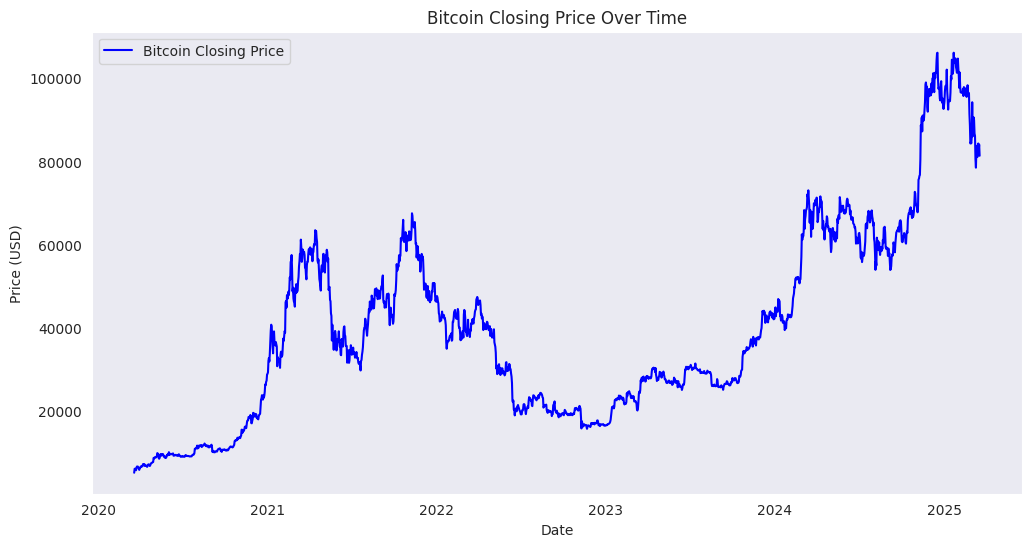

In [179]:
# Plot the closing price trend
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Bitcoin Closing Price", color="blue")  # Use df.index instead of df["Date"]
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()

## Feature Engineering

### The Exponential Moving Average (EMA)
- gives more weight to recent prices, making it more responsive than the Simple Moving Average (SMA)

In [180]:
# Calculate EMA for different periods
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()

# Drop NaN values caused by EMA calculation
df.dropna(inplace=True)

# Display the first few rows to verify
print(df.head())

                  Close         High          Low         Open       Volume  \
Date                                                                          
2020-03-18  5238.438477  5331.833984  5069.335938  5227.113770  37878801016   
2020-03-19  6191.192871  6329.735840  5236.968750  5245.416504  51000731797   
2020-03-20  6198.778320  6844.261719  5865.781738  6191.653809  54442976103   
2020-03-21  6185.066406  6378.135254  5932.823242  6206.521484  42494390880   
2020-03-22  5830.254883  6359.697266  5823.713867  6185.558105  40099664740   

                 EMA_10       EMA_20       EMA_50  
Date                                               
2020-03-18  5238.438477  5238.438477  5238.438477  
2020-03-19  5411.666548  5329.176990  5275.801394  
2020-03-20  5554.777780  5411.996165  5311.996568  
2020-03-21  5669.375712  5485.621902  5346.234600  
2020-03-22  5698.626470  5518.444091  5365.215788  


### Relative Strength Index (RSI)
- The Relative Strength Index (RSI) is a momentum indicator that measures the speed and change of price movements.
- It helps identify overbought and oversold conditions.



In [181]:
def calculate_rsi(data, window=14):
    delta = data["Close"].diff(1)  # Price change between days
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss  # Relative Strength
    rsi = 100 - (100 / (1 + rs))  # RSI Formula

    return rsi

# Apply RSI calculation to the dataset
df["RSI_14"] = calculate_rsi(df)

# Drop NaN values caused by rolling calculations
df.dropna(inplace=True)

# Display the first few rows to verify
print(df.head())

                  Close         High          Low         Open       Volume  \
Date                                                                          
2020-03-31  6438.644531  6504.515137  6374.162109  6430.606445  32786468812   
2020-04-01  6606.776367  6612.573730  6202.373535  6437.319336  40346426266   
2020-04-02  6793.624512  7088.247559  6595.918457  6606.776367  47660646124   
2020-04-03  6733.387207  7003.220703  6673.335938  6797.396484  38976504903   
2020-04-04  6867.527344  6878.953613  6696.484863  6738.382812  33185988584   

                 EMA_10       EMA_20       EMA_50     RSI_14  
Date                                                          
2020-03-31  6279.986976  6053.645532  5689.488737  66.515706  
2020-04-01  6339.403229  6106.324659  5725.460801  67.996579  
2020-04-02  6421.988916  6171.781788  5767.349574  59.922271  
2020-04-03  6478.606787  6225.268018  5805.233402  58.655092  
2020-04-04  6549.319616  6286.435573  5846.891988  60.634092  


### Moving Average Convergence Divergence (MACD)
- The MACD (Moving Average Convergence Divergence) is a trend-following momentum indicator that shows the relationship between two moving averages of an asset’s price.

In [182]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data["Close"].ewm(span=short_window, adjust=False).mean()
    long_ema = data["Close"].ewm(span=long_window, adjust=False).mean()

    data["MACD"] = short_ema - long_ema  # MACD Line
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_window, adjust=False).mean()  # Signal Line

    return data

# Apply MACD calculation to the dataset
df = calculate_macd(df)

# Drop NaN values caused by rolling calculations
df.dropna(inplace=True)

# Display the first few rows to verify
print(df.head())

                  Close         High          Low         Open       Volume  \
Date                                                                          
2020-03-31  6438.644531  6504.515137  6374.162109  6430.606445  32786468812   
2020-04-01  6606.776367  6612.573730  6202.373535  6437.319336  40346426266   
2020-04-02  6793.624512  7088.247559  6595.918457  6606.776367  47660646124   
2020-04-03  6733.387207  7003.220703  6673.335938  6797.396484  38976504903   
2020-04-04  6867.527344  6878.953613  6696.484863  6738.382812  33185988584   

                 EMA_10       EMA_20       EMA_50     RSI_14       MACD  \
Date                                                                      
2020-03-31  6279.986976  6053.645532  5689.488737  66.515706   0.000000   
2020-04-01  6339.403229  6106.324659  5725.460801  67.996579  13.412226   
2020-04-02  6421.988916  6171.781788  5767.349574  59.922271  38.672800   
2020-04-03  6478.606787  6225.268018  5805.233402  58.655092  53.217877

### Splitting Data

In [183]:
# Define the number of days for testing
test_days = 60

# Split the data
train_data = df.iloc[:-test_days]  # All data except last 60 days
test_data = df.iloc[-test_days:]   # Last 60 days for testing

# Print dataset sizes
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Separate features and target variable (Close Price)
features = ["Volume", "EMA_10", "EMA_20", "EMA_50", "RSI_14", "MACD", "MACD_Signal"]
target = "Close"

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training data shape: (1754, 11)
Testing data shape: (60, 11)
X_train shape: (1754, 7), y_train shape: (1754,)
X_test shape: (60, 7), y_test shape: (60,)


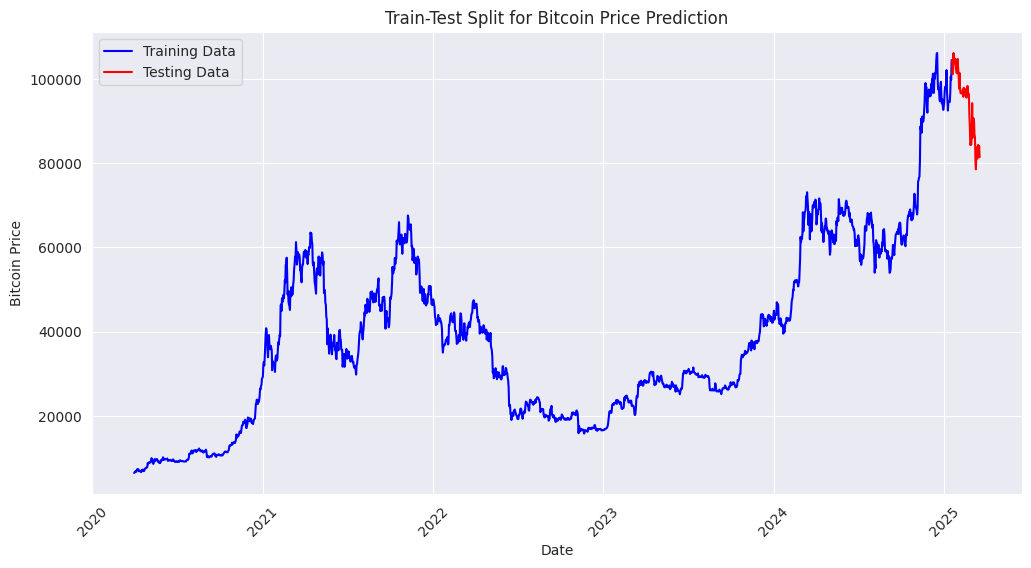

In [184]:
plt.figure(figsize=(12, 6))

# Highlight the training data
plt.plot(train_data.index, train_data["Close"], label="Training Data", color="blue")

# Highlight the testing data
plt.plot(test_data.index, test_data["Close"], label="Testing Data", color="red")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Train-Test Split for Bitcoin Price Prediction")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Test Set

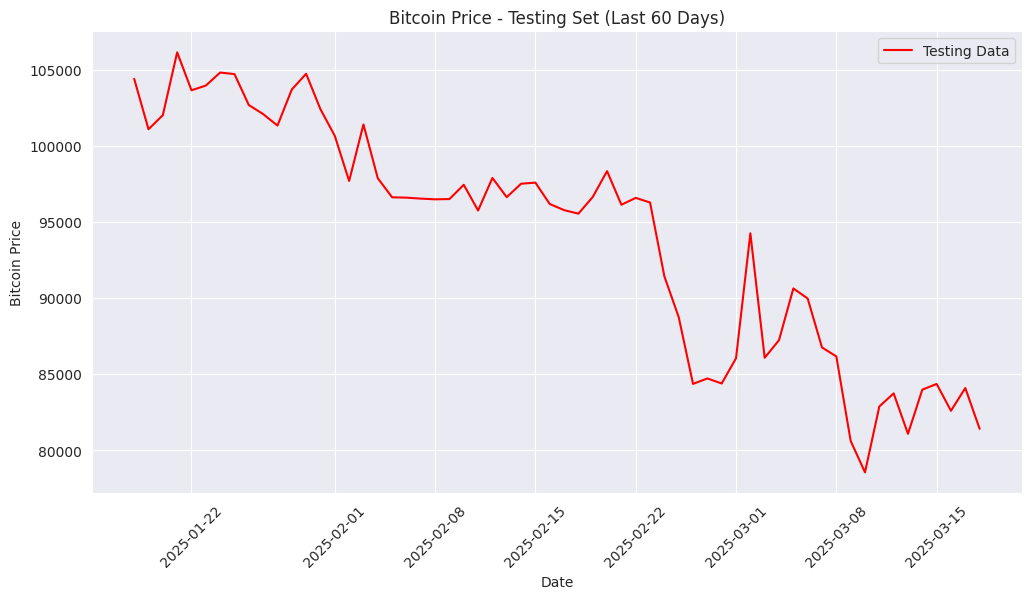

In [185]:
# Plot only the testing data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["Close"], label="Testing Data", color="red")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price - Testing Set (Last 60 Days)")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Feature Scaling

In [186]:
# Select only the columns that were originally scaled
features = ["Close", "EMA_10", "EMA_20", "RSI_14", "MACD", "MACD_Signal"]

# Transform only the selected features
X_train_scaled = scaler.transform(train_data[features])
X_test_scaled = scaler.transform(test_data[features])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=train_data.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=test_data.index)

# Print first few rows to verify
print(X_train_scaled.head())
print(X_test_scaled.head())

               Close    EMA_10    EMA_20    RSI_14      MACD  MACD_Signal
Date                                                                     
2020-03-31  0.000000  0.000000  0.000000  0.646910  0.417540     0.408492
2020-04-01  0.001686  0.000614  0.000550  0.662898  0.418648     0.408739
2020-04-02  0.003560  0.001467  0.001233  0.575723  0.420735     0.409402
2020-04-03  0.002956  0.002052  0.001791  0.562041  0.421937     0.410199
2020-04-04  0.004301  0.002782  0.002429  0.583408  0.423713     0.411233
               Close    EMA_10    EMA_20    RSI_14      MACD  MACD_Signal
Date                                                                     
2025-01-18  0.982567  0.962696  0.960782  0.590241  0.523253     0.435562
2025-01-19  0.949285  0.965710  0.963716  0.517499  0.528912     0.454956
2025-01-20  0.958583  0.969918  0.967291  0.467403  0.538187     0.472536
2025-01-21  1.000000  0.981115  0.974630  0.654615  0.571299     0.493976
2025-01-22  0.974995  0.985595  0.9787

### Define Sequences for LSTM

In [187]:
# Define lookback period (number of past days used for prediction)
lookback = 5

# Function to create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i : i + lookback].values)  # Last 5 days
        y.append(data.iloc[i + lookback]["Close"])  # Target: next day's price
    return np.array(X), np.array(y)

# Create sequences for train and test sets
X_train, y_train = create_sequences(X_train_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, lookback)

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1749, 5, 6), y_train shape: (1749,)
X_test shape: (55, 5, 6), y_test shape: (55,)


### Define the LSTM Model

In [189]:
# Function to build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, activation='tanh', input_shape=input_shape),
        Dropout(0.3),

        LSTM(units=40, return_sequences=False, activation='tanh'),
        Dropout(0.3),

        Dense(units=30, activation='relu'),
        Dense(units=1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

    return model

# Define input shape for LSTM (based on X_train shape)
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)

# Build the model
model = build_lstm_model(input_shape)

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                       │ (None, 5, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,221 (106.33 KB)

 Trainable params: 27,221 (106.33 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [190]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping with a clear notification
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

print("🛑 Early stopping triggered. Training has stopped.")  # Notification

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1498 - val_loss: 0.5461
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - val_loss: 0.2067
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 - val_loss: 0.1037
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - val_loss: 0.0436
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - val_loss: 0.0126
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

### Training Loss Curve

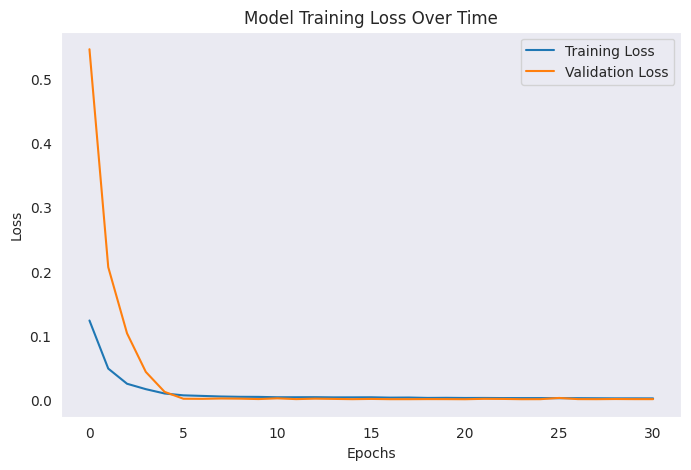

In [191]:
# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Loss Over Time')
plt.legend()
plt.grid()
plt.show()

### Predictions on the Test Set

In [192]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Mean Absolute Error (MAE): 0.02684104541638117
Root Mean Squared Error (RMSE): 0.03378118337340607
R² Score: 0.7965944971860746


In [193]:
df_comparison = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_prices.ravel(),  # Convert to 1D
    "Predicted Price": predictions.ravel()  # Convert to 1D
})

# Add a column for the difference
df_comparison["Difference"] = df_comparison["Actual Price"] - df_comparison["Predicted Price"]

# Display first few rows
print(df_comparison.tail(15))

         Date  Actual Price  Predicted Price   Difference
40 2025-03-04  87222.195312     83596.921875  3625.273438
41 2025-03-05  90623.562500     84559.585938  6063.976562
42 2025-03-06  89961.726562     86504.539062  3457.187500
43 2025-03-07  86742.671875     88477.617188 -1734.945312
44 2025-03-08  86154.593750     85380.023438   774.570312
45 2025-03-09  80601.039062     86515.046875 -5914.007812
46 2025-03-10  78532.000000     87291.835938 -8759.835938
47 2025-03-11  82862.210938     85609.000000 -2746.789062
48 2025-03-12  83722.359375     83121.765625   600.593750
49 2025-03-13  81066.703125     81382.679688  -315.976562
50 2025-03-14  83969.101562     78974.023438  4995.078125
51 2025-03-15  84343.109375     79194.835938  5148.273438
52 2025-03-16  82579.687500     81173.406250  1406.281250
53 2025-03-17  84075.687500     81258.968750  2816.718750
54 2025-03-18  81393.726562     80802.390625   591.335938


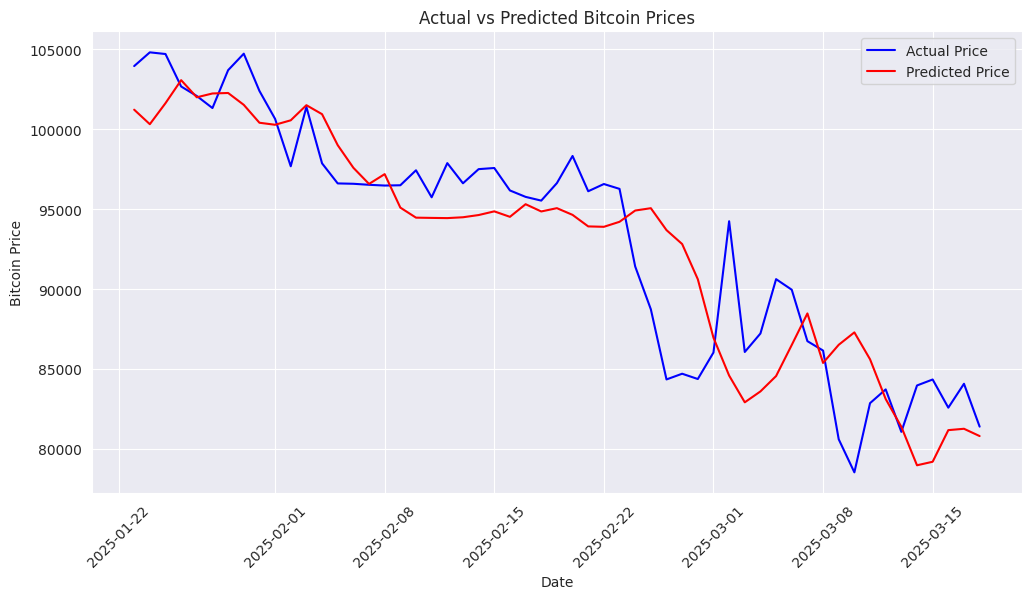

In [197]:
plt.figure(figsize=(12,6))
plt.plot(df_comparison["Date"], df_comparison["Actual Price"], label="Actual Price", color="blue")
plt.plot(df_comparison["Date"], df_comparison["Predicted Price"], label="Predicted Price", color="red")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.title("Actual vs Predicted Bitcoin Prices")
plt.show()

### Model Evaluation

In [194]:
# Calculate MAE
mae = mean_absolute_error(df_comparison["Actual Price"], df_comparison["Predicted Price"])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_comparison["Actual Price"], df_comparison["Predicted Price"]))

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 2853.1879
Root Mean Squared Error (RMSE): 3705.4414
